# Classification of mushroom species

The objective of this notebook is to build a model predicting the species of the given fungus picture.
In US alone there are 7500 yearly cases of fungi poisoning. Proper identification of the species could prevent deaths and hospitalization costs.

Wikipedia specifies the most toxis fungis:
https://en.wikipedia.org/wiki/List_of_poisonous_fungus_species

The analysis is done on dataset from https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images.

Taking into account the species from dataset and information from wikipedia we need to be highly alert over species like:
* Amonita
* Cortinarius
* Enteloma
* Lactarius
* some species of Boletus
* some species of Rusella

which takes 5 out of 9 species that we have in our dataset.

The aim is to build the models that would recognize those species. The metric that will be used is multiclass accuracy.

## Setup

### Installations

In [ ]:
# @title
!pip install --quiet kaggle
!pip install --quiet fastai
!pip install --quiet pytorch-lightning
!pip install --quiet torchmetrics
!pip install --quiet tensorboard

### Importing libraries

In [6]:
# @title
from google.colab import files
import os
import zipfile
import shutil
from typing import Tuple, List
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import LambdaLR
torch.manual_seed(42)

from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torchvision.datasets.imagenet import ImageNet
from torchvision.transforms import AutoAugmentPolicy, AutoAugment

from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback

from torchmetrics.classification import  Accuracy

import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [9]:
# @title
def list_directory_tree_with_os_walk(starting_directory: str) -> Tuple[List]:
    """Creates list of species of mushrooms and calculates the number
    of files in each of directory.
    Args:
        starting directory(str)
    Returns:
        list of directories with mushroom species
        list of number of files in each directory"""

    roots = []
    file_nr = []
    for root, directories, files in os.walk(starting_directory):
        root = root.split("/")[-1]
        roots.append(root)
        file_nr.append(len(files))
    return roots[1:], file_nr[1:]

def assign_data_split(x: str) -> str:
    """Mapping function that assigns split to the file path.
    Args:
        x (str): image path
    Returns:
        (str): assigned split word"""

    if x in X_train.tolist():
        return 'train'
    elif x in X_val.tolist():
        return 'valid'
    elif x in X_test.tolist():
        return 'test'

def copy_paths(z:str, s:str) -> None:
    """Copies file to a destination folder based on columns from df_files.
    Args:
        z (str): folder
        s (str): file path"""

    destination = f'/content/data/{z}/{s}'
    for path in df_files.loc[(df_files['split']==z)&(df_files['species']==s)]['path'].tolist():
        shutil.copy(path, destination)


def display_image_grid(images: List, labels: List, rows: int=2, cols: int=5):
    """
    Display a grid of images with labels.
    Args:
        images (list of numpy arrays): list of images to display.
        labels (list of str): list of labels for each image.
        rows (int): number of rows in the grid (default is 2).
        cols (int): number of columns in the grid (default is 5).
    """

    if len(images) != rows * cols:
        raise ValueError("Number of images should match rows * cols.")

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(labels[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def augment_images(source_dir: str, num_augmentations: int=5):
    """
    Augment images in a source directory and save them to a destination directory.

    Args:
        source_dir (str): path to the source directory containing input images.
        num_augmentations (int): number of augmentations to generate per input image (default is 5).
    """
    augmentation = transforms.Compose([
        AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
    ])
    file_list = os.listdir(source_dir)

    for i in range(num_augmentations):
        random_file = random.choice(file_list)
        random_path = os.path.join(source_dir, random_file)
        input_image = Image.open(random_path)
        augmented_image = augmentation(input_image)
        new_filename = f"{os.path.splitext(random_file)[0]}_aug_{i+1}{os.path.splitext(random_file)[1]}"
        augmented_image.save(os.path.join(source_dir, new_filename))


def plot_training(epochs: List[int], train_losses: List,
                  valid_losses: List, train_acces: List, valid_acces: List):
    """Plots two graphs of losses and accuracies for training and validation
    on each epoch.
    Args:
        epochs (list): range of epochs
        train_losses (list): losses on all epochs for train data
        valid_losses (list): losses on all epochs for validation data
        train_acces (list): accuracies on all epochs for train data
        valid_acces (list): accuracies on all epochs for validation data"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(epochs, valid_losses[1:], label='Validation Loss')
    ax1.plot(epochs, train_losses, label='Training Loss')
    ax1.legend()
    ax1.set_title('Losses on epochs')
    ax2.plot(epochs, valid_acces[1:], label='Validation accuracy')
    ax2.plot(epochs, train_acces, label='Trining accuracy')
    ax2.legend()
    ax2.set_title('Accuracies on epochs')
    plt.show()

## Downloading data

To download the data:
* download kaggle API token in .json format from kaggle
* when promped download the file with kaggle credentials

In [ ]:
# Downlading file with kaggle API token
files.upload()
# Seetting kaggle
!pip show kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config view
# Downlading dataset
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
# Extracting download to data file
zip_file_path = "/content/mushrooms-classification-common-genuss-images.zip"
with zipfile.ZipFile(zip_file_path, 'r') as d:
    d.extractall("/content/data")

Saving kaggle.json to kaggle.json
Name: kaggle
Version: 1.5.16
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 
Configuration values from /root/.kaggle
- username: malgorzatakolka
- path: None
- proxy: None
- competition: None
 99% 1.84G/1.85G [00:19<00:00, 121MB/s]
100% 1.85G/1.85G [00:19<00:00, 102MB/s]


## Inspecting the structure of the dataset

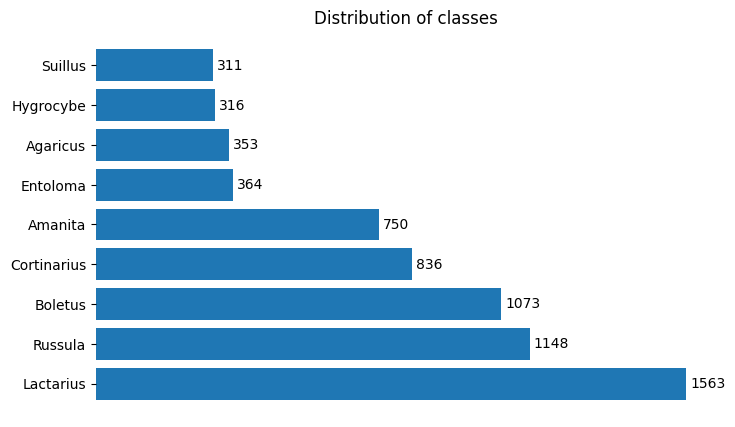

In [ ]:
# Getting names of species and count of pictures for each species
species, count = list_directory_tree_with_os_walk("/content/data/Mushrooms")


df = pd.DataFrame()
df['Species'] = species
df['Count'] = count
df.sort_values(by=['Count'], ascending=False, inplace=True)
plt.figure(figsize=(8, 5))
plt.barh(df['Species'], df['Count'])
for i, v in enumerate(df['Count']):
    plt.text(v + 10, i, str(v), va='center', fontsize=10)
sns.despine(bottom=True, left=True)
plt.xticks([])
plt.title('Distribution of classes')
plt.show()

The data is imbalanced with some of the species having 5 times more samples. Later in the modeling stage the data will be balanced by augmentation.

## Stratified data split and folder creation for train, validation and testing

In [ ]:
# Get all paths of images
filenames = []
for root, directories, files in os.walk("/content/data/Mushrooms"):
    for f in files:
        filename = os.path.join(root, f)
        filenames.append(filename)

# Crating dataframe which will hold the path and species
df_files = pd.DataFrame()
df_files['path'] = filenames
df_files['species'] = df_files['path'].apply(lambda x: x.split("/")[4])

# Splitting data
X = df_files['path']
y = df_files['species']

X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=0.5, stratify=y_t, random_state=42)

# Mapping splits with split column
df_files['split'] = df_files['path'].map(assign_data_split)

# Preparation of directories
directory_list = [f"/content/data/{z}/{s}" for z in ['train', 'valid', 'test']
                  for s in df_files['species'].unique().tolist()]
for directory in directory_list:
    os.makedirs(directory, exist_ok=True)

# Coping files
for z in ['train', 'valid', 'test']:
    for s in df_files['species'].unique().tolist():
        copy_paths(z, s)

In [ ]:
drive_path = "/content/data"
train_roots, train_files = list_directory_tree_with_os_walk(f"{drive_path}/train")
valid_roots, valid_files = list_directory_tree_with_os_walk(f"{drive_path}/valid")
test_roots, test_files = list_directory_tree_with_os_walk(f"{drive_path}/test")
print("Species: ", train_roots)
print("Train: ", train_files)
print("Valid: ", valid_files)
print("Test: ", test_files)

Species:  ['Cortinarius', 'Entoloma', 'Suillus', 'Agaricus', 'Lactarius', 'Russula', 'Hygrocybe', 'Boletus', 'Amanita']
Train:  [585, 255, 218, 247, 1094, 803, 221, 751, 525]
Valid:  [125, 55, 47, 53, 234, 172, 48, 161, 112]
Test:  [126, 54, 46, 53, 235, 173, 47, 161, 113]


## Displaying random samples of pictures from training set

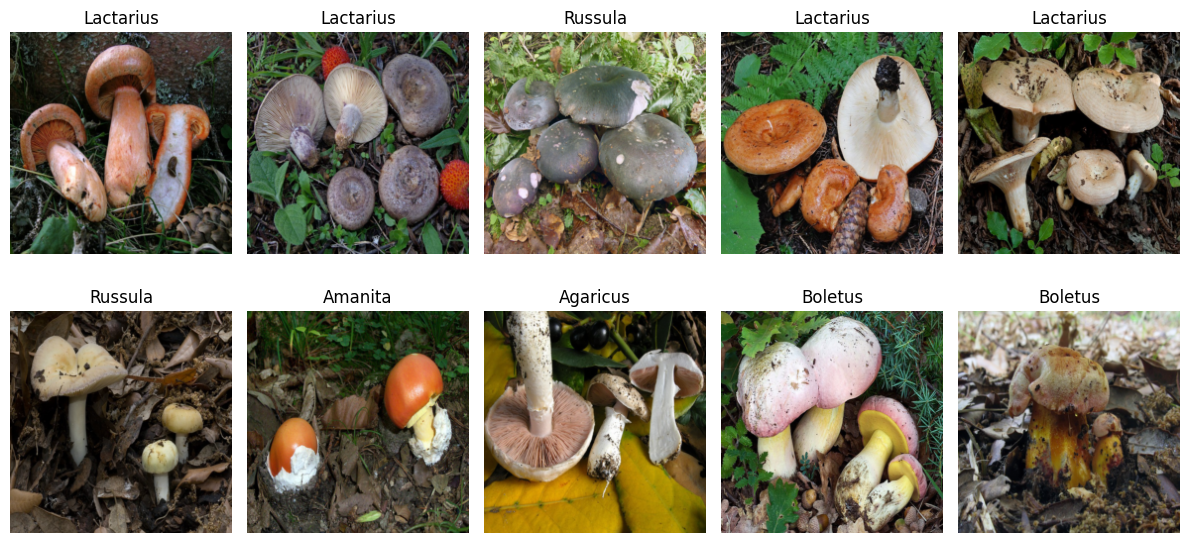

In [ ]:
# Creating transformer
tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating data loader
train_data = datasets.ImageFolder(f"/content/data/train", transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

# Displaying pictures for first batch of 10 mushrooms
label_mapper = {i:c for i, c in enumerate(train_data.classes)}
images, labels = next(iter(train_loader))
labels = [label_mapper[label.item()] for label in labels]
display_image_grid(images, labels)

In [ ]:
label_mapper

{0: 'Agaricus',
 1: 'Amanita',
 2: 'Boletus',
 3: 'Cortinarius',
 4: 'Entoloma',
 5: 'Hygrocybe',
 6: 'Lactarius',
 7: 'Russula',
 8: 'Suillus'}

## Model Building using FastAI and ResNet18

First experiment will be focused on creating model using FastAI library.
The data won't be augmented so the training will take less time.

TODO:
* create dataloader and display batch
* create learner
* find the best learning rate
* finetune the model with heavy penalization
* analyze model performance


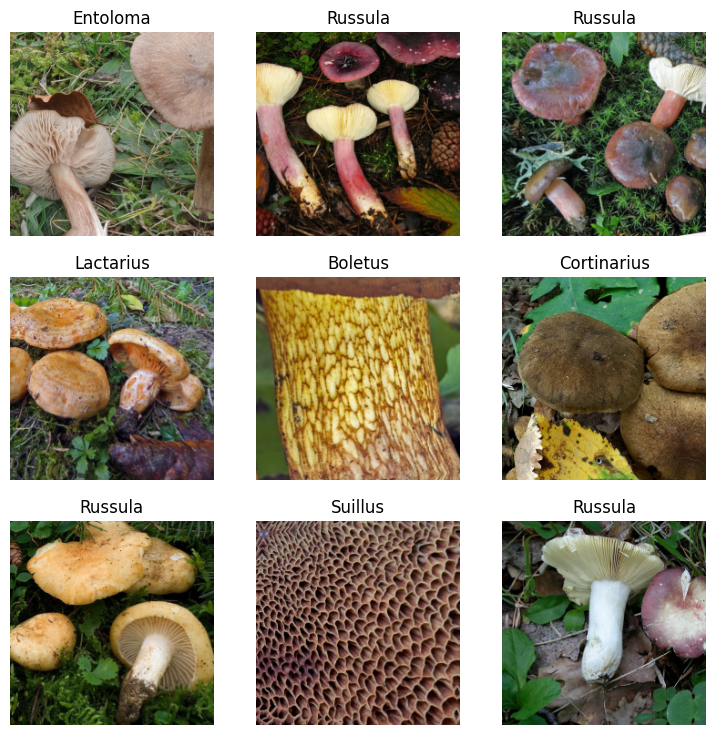

In [ ]:
dls = ImageDataLoaders.from_folder(
    path='/content/data',
    train='train',
    valid='valid',
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

dls.show_batch()

In [ ]:
# Instantiating learner
learn = cnn_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

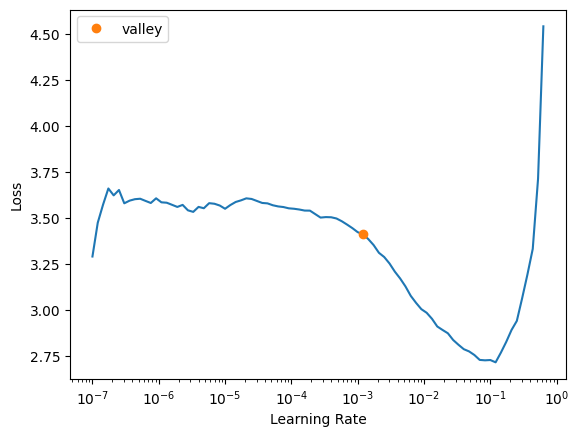

In [ ]:
# Finding learning rate
learn.lr_find()

In [ ]:
# Fine tuning the model
learn.fine_tune(epochs=10, base_lr=0.0012, wd=0.8)

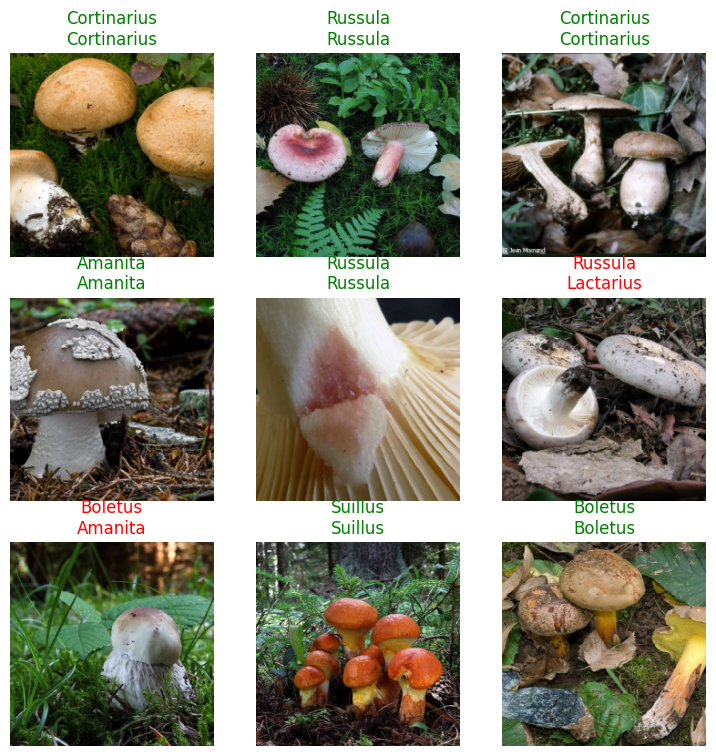

In [ ]:
# Results for first 9 mushrooms
learn.show_results()

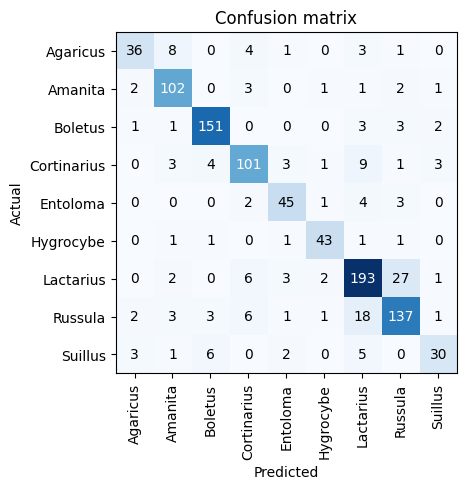

In [ ]:
# Creating confusion matrix
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

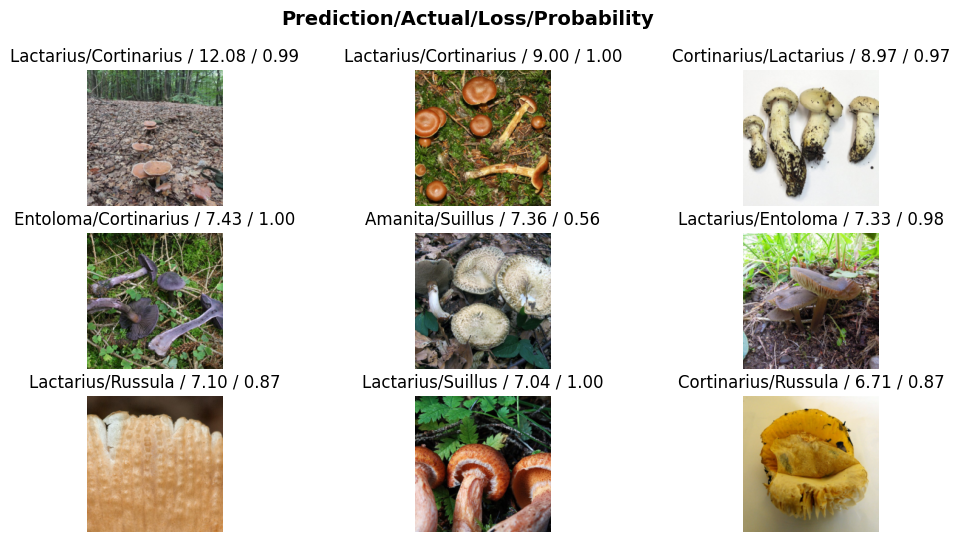

In [ ]:
interpretation.plot_top_losses(9, figsize=(12,6))

The classes that have similar shape or mashrooms were misclassified although they had the highiest number of representatives.

The most worring cases are the species which are toxic but are classified as eadible. In the graph displayed above non of those may actually cause harm to the mushroom picker.

## Model building with Pytorch-lightning and ResNet18

1. Experiment without data augmentation
2. Experiment with data augmentation

### Defining the model

In [ ]:
class MushroomResNet(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.learning_rate = 0.001
        weights = ResNet18_Weights.DEFAULT
        backbone = resnet18(weights=weights)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        num_target_classes = 9
        self.dropout = nn.Dropout(p=0.6)
        self.classifier = nn.Linear(num_filters, num_target_classes)
        self.accuracy = Accuracy(task="multiclass", num_classes=9)

    def forward(self, x):
        out = self.feature_extractor(x).flatten(1)
        out = self.dropout(out)
        out = self.classifier(out)
        return out

    def training_step(self, batch, batch_idx):
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, on_step=False, prog_bar=True)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, on_step=False, prog_bar=True)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch, batch_idx):
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        self.log("test_acc", acc, on_epoch=True)
        return {"loss": loss, "acc": acc}

    def _common_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        return loss, acc, outputs, labels

    def predict_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(-1, 3, 244, 244)
        outputs = self.forward(images)
        pred = torch.argmax(outputs, dim=1)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate)
        scheduler = {
            'scheduler': LambdaLR(optimizer,
                                  lr_lambda=lambda epoch: self.adjust_lr(epoch)),
            'interval': 'epoch',
             'frequency': 1,
        }
        return [optimizer], [scheduler]

    def adjust_lr(self, epoch):
        min_lr = 0.0005
        max_lr = 0.004
        return min_lr + (max_lr - min_lr) * (1 - epoch / self.trainer.max_epochs)



class MyPrintingCallback(Callback):
    def __init__(self):
        self.train_val_time = 0
        self.train_losses = []
        self.valid_losses = []
        self.train_acces = []
        self.valid_acces = []

    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        self.train_val_time += epoch_duration

        train_acc = trainer.callback_metrics['train_acc']
        self.train_acces.append(train_acc.item())
        train_loss = trainer.callback_metrics['train_loss']
        self.train_losses.append(train_loss.item())
        print(f"Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
              f"Epoch Duration: {epoch_duration:.2f} seconds")

    def on_validation_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        self.train_val_time += epoch_duration
        valid_acc = trainer.callback_metrics['val_acc']
        self.valid_acces.append(valid_acc.item())
        valid_loss = trainer.callback_metrics['val_loss']
        self.valid_losses.append(valid_loss.item())
        print(f"Epoch {trainer.current_epoch}: valid_loss={valid_loss:.4f}, valid_acc={valid_acc:.4f}, "
              f"Epoch Duration: {epoch_duration:.2f} seconds")

    def on_fit_end(self, trainer, pl_module):
        print(f"Training and validation time: {self.train_val_time/60:.2f}min")
        epochs = range(trainer.current_epoch)
        plot_training(epochs, self.train_losses, self.valid_losses, self.train_acces, self.valid_acces)


early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3, mode='min')
logger = TensorBoardLogger("logs/", name="mushroom_exp")
model = MushroomResNet()
trainer = pl.Trainer(max_epochs=30,
                     logger=logger,
                     callbacks=[early_stopping, MyPrintingCallback()])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Defining transformations
tfms = transforms.Compose([transforms.Resize((244, 244)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

# Defining dataloaders
train_data = datasets.ImageFolder('/content/data/train',
                                    transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32,
                                            shuffle=True)

valid_data = datasets.ImageFolder('/content/data/valid',
                                    transform=tfms)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                            batch_size=32,
                                            shuffle=False)

test_data = datasets.ImageFolder('/content/data/test',
                                    transform=tfms)
test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=32,
                                            shuffle=False)

### Model without data augmentation

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 11.2 M
1 | dropout           | Dropout            | 0     
2 | classifier        | Linear             | 4.6 K 
3 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: valid_loss=2.5766, valid_acc=0.0000, Epoch Duration: 0.63 seconds
Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: valid_loss=2.0304, valid_acc=0.2483, Epoch Duration: 9.03 seconds
Epoch 0: train_loss=2.4561, train_acc=0.1398, Epoch Duration: 9.04 seconds


Validation: 0it [00:00, ?it/s]

Epoch 1: valid_loss=1.7746, valid_acc=0.4459, Epoch Duration: 9.12 seconds
Epoch 1: train_loss=2.1465, train_acc=0.2179, Epoch Duration: 9.13 seconds


Validation: 0it [00:00, ?it/s]

Epoch 2: valid_loss=1.5575, valid_acc=0.5452, Epoch Duration: 9.54 seconds
Epoch 2: train_loss=1.9073, train_acc=0.3220, Epoch Duration: 9.55 seconds


Validation: 0it [00:00, ?it/s]

Epoch 3: valid_loss=1.4014, valid_acc=0.5909, Epoch Duration: 10.10 seconds
Epoch 3: train_loss=1.6982, train_acc=0.4082, Epoch Duration: 10.11 seconds


Validation: 0it [00:00, ?it/s]

Epoch 4: valid_loss=1.2881, valid_acc=0.6077, Epoch Duration: 10.37 seconds
Epoch 4: train_loss=1.5395, train_acc=0.4675, Epoch Duration: 10.38 seconds


Validation: 0it [00:00, ?it/s]

Epoch 5: valid_loss=1.1939, valid_acc=0.6207, Epoch Duration: 10.48 seconds
Epoch 5: train_loss=1.3999, train_acc=0.5256, Epoch Duration: 10.49 seconds


Validation: 0it [00:00, ?it/s]

Epoch 6: valid_loss=1.1216, valid_acc=0.6465, Epoch Duration: 12.74 seconds
Epoch 6: train_loss=1.2892, train_acc=0.5718, Epoch Duration: 12.76 seconds


Validation: 0it [00:00, ?it/s]

Epoch 7: valid_loss=1.0662, valid_acc=0.6554, Epoch Duration: 18.43 seconds
Epoch 7: train_loss=1.2110, train_acc=0.5912, Epoch Duration: 18.44 seconds


Validation: 0it [00:00, ?it/s]

Epoch 8: valid_loss=1.0186, valid_acc=0.6634, Epoch Duration: 16.59 seconds
Epoch 8: train_loss=1.1396, train_acc=0.6255, Epoch Duration: 16.60 seconds


Validation: 0it [00:00, ?it/s]

Epoch 9: valid_loss=0.9777, valid_acc=0.6783, Epoch Duration: 14.28 seconds
Epoch 9: train_loss=1.0803, train_acc=0.6455, Epoch Duration: 14.29 seconds


Validation: 0it [00:00, ?it/s]

Epoch 10: valid_loss=0.9455, valid_acc=0.6872, Epoch Duration: 9.73 seconds
Epoch 10: train_loss=1.0130, train_acc=0.6761, Epoch Duration: 9.74 seconds


Validation: 0it [00:00, ?it/s]

Epoch 11: valid_loss=0.9104, valid_acc=0.6941, Epoch Duration: 9.75 seconds
Epoch 11: train_loss=0.9767, train_acc=0.6801, Epoch Duration: 9.76 seconds


Validation: 0it [00:00, ?it/s]

Epoch 12: valid_loss=0.8855, valid_acc=0.7001, Epoch Duration: 11.99 seconds
Epoch 12: train_loss=0.9292, train_acc=0.7001, Epoch Duration: 12.00 seconds


Validation: 0it [00:00, ?it/s]

Epoch 13: valid_loss=0.8578, valid_acc=0.7061, Epoch Duration: 10.48 seconds
Epoch 13: train_loss=0.8961, train_acc=0.7110, Epoch Duration: 10.49 seconds


Validation: 0it [00:00, ?it/s]

Epoch 14: valid_loss=0.8397, valid_acc=0.7269, Epoch Duration: 10.42 seconds
Epoch 14: train_loss=0.8555, train_acc=0.7172, Epoch Duration: 10.42 seconds


Validation: 0it [00:00, ?it/s]

Epoch 15: valid_loss=0.8238, valid_acc=0.7249, Epoch Duration: 11.83 seconds
Epoch 15: train_loss=0.8202, train_acc=0.7340, Epoch Duration: 11.84 seconds


Validation: 0it [00:00, ?it/s]

Epoch 16: valid_loss=0.8047, valid_acc=0.7329, Epoch Duration: 10.30 seconds
Epoch 16: train_loss=0.7972, train_acc=0.7436, Epoch Duration: 10.31 seconds


Validation: 0it [00:00, ?it/s]

Epoch 17: valid_loss=0.7917, valid_acc=0.7398, Epoch Duration: 14.14 seconds
Epoch 17: train_loss=0.7619, train_acc=0.7568, Epoch Duration: 14.14 seconds


Validation: 0it [00:00, ?it/s]

Epoch 18: valid_loss=0.7718, valid_acc=0.7428, Epoch Duration: 10.44 seconds
Epoch 18: train_loss=0.7354, train_acc=0.7717, Epoch Duration: 10.45 seconds


Validation: 0it [00:00, ?it/s]

Epoch 19: valid_loss=0.7623, valid_acc=0.7498, Epoch Duration: 10.62 seconds
Epoch 19: train_loss=0.7113, train_acc=0.7778, Epoch Duration: 10.64 seconds


Validation: 0it [00:00, ?it/s]

Epoch 20: valid_loss=0.7548, valid_acc=0.7478, Epoch Duration: 10.30 seconds
Epoch 20: train_loss=0.6990, train_acc=0.7770, Epoch Duration: 10.31 seconds


Validation: 0it [00:00, ?it/s]

Epoch 21: valid_loss=0.7415, valid_acc=0.7577, Epoch Duration: 9.59 seconds
Epoch 21: train_loss=0.6814, train_acc=0.7838, Epoch Duration: 9.60 seconds


Validation: 0it [00:00, ?it/s]

Epoch 22: valid_loss=0.7351, valid_acc=0.7567, Epoch Duration: 9.30 seconds
Epoch 22: train_loss=0.6654, train_acc=0.7895, Epoch Duration: 9.31 seconds


Validation: 0it [00:00, ?it/s]

Epoch 23: valid_loss=0.7246, valid_acc=0.7696, Epoch Duration: 9.17 seconds
Epoch 23: train_loss=0.6415, train_acc=0.7989, Epoch Duration: 9.18 seconds


Validation: 0it [00:00, ?it/s]

Epoch 24: valid_loss=0.7152, valid_acc=0.7646, Epoch Duration: 9.58 seconds
Epoch 24: train_loss=0.6330, train_acc=0.8046, Epoch Duration: 9.59 seconds


Validation: 0it [00:00, ?it/s]

Epoch 25: valid_loss=0.7114, valid_acc=0.7676, Epoch Duration: 10.51 seconds
Epoch 25: train_loss=0.6086, train_acc=0.8134, Epoch Duration: 10.52 seconds


Validation: 0it [00:00, ?it/s]

Epoch 26: valid_loss=0.7113, valid_acc=0.7776, Epoch Duration: 10.44 seconds
Epoch 26: train_loss=0.5980, train_acc=0.8170, Epoch Duration: 10.45 seconds


Validation: 0it [00:00, ?it/s]

Epoch 27: valid_loss=0.7041, valid_acc=0.7666, Epoch Duration: 10.53 seconds
Epoch 27: train_loss=0.5987, train_acc=0.8174, Epoch Duration: 10.54 seconds


Validation: 0it [00:00, ?it/s]

Epoch 28: valid_loss=0.7011, valid_acc=0.7776, Epoch Duration: 10.67 seconds
Epoch 28: train_loss=0.5861, train_acc=0.8191, Epoch Duration: 10.68 seconds


Validation: 0it [00:00, ?it/s]

Epoch 29: valid_loss=0.6955, valid_acc=0.7746, Epoch Duration: 10.74 seconds
Epoch 29: train_loss=0.5863, train_acc=0.8244, Epoch Duration: 10.75 seconds


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Training and validation time: 11.06min


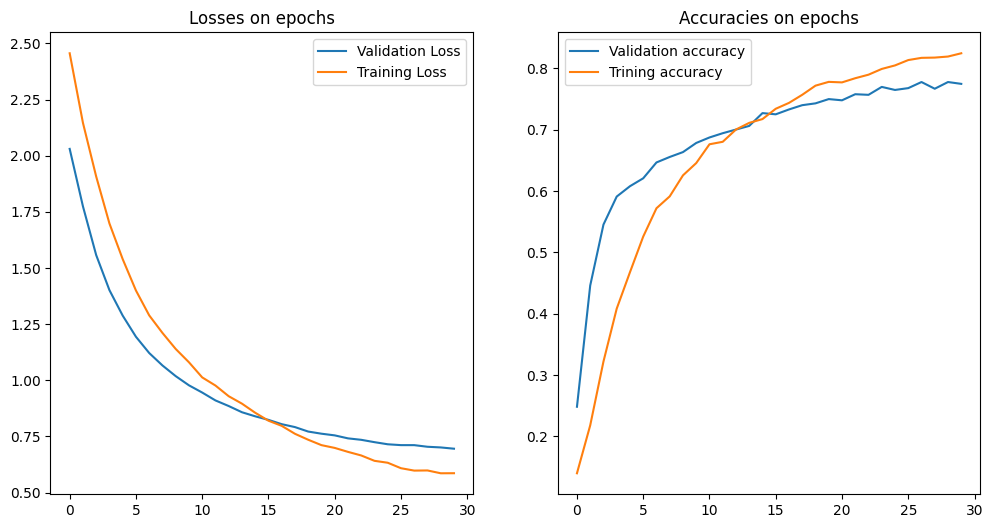

In [ ]:
trainer.fit(model, train_loader, valid_loader)

### Model with augmented and balanced dataset

In this experiment the data will be augmented so each specie has 2000 sample images.

In [ ]:
# Augmenting data to get 2000 images from each class
nr_samples = 2500
for root in train_roots:
    source_dir = f"/content/data/train/{root}"
    nr_files = len(os.listdir(source_dir))
    num_augmentations = nr_samples - nr_files
    augment_images(source_dir, num_augmentations)

In [ ]:
# Inspecting distribution of samples
drive_path = "/content/data"
train_roots, train_files = list_directory_tree_with_os_walk(f"{drive_path}/train")
valid_roots, valid_files = list_directory_tree_with_os_walk(f"{drive_path}/valid")
test_roots, test_files = list_directory_tree_with_os_walk(f"{drive_path}/test")
print("Species: ", train_roots)
print("Train: ", train_files)
print("Valid: ", valid_files)
print("Test: ", test_files)

Species:  ['Cortinarius', 'Entoloma', 'Suillus', 'Agaricus', 'Lactarius', 'Russula', 'Hygrocybe', 'Boletus', 'Amanita']
Train:  [2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500]
Valid:  [125, 55, 47, 53, 234, 172, 48, 161, 112]
Test:  [126, 54, 46, 53, 235, 173, 47, 161, 113]


In [ ]:
# Defining transformations
tfms = transforms.Compose([transforms.Resize((244, 244)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

# Defining dataloaders
train_data = datasets.ImageFolder('/content/data/train',
                                    transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=32,
                                            shuffle=True)

valid_data = datasets.ImageFolder('/content/data/valid',
                                    transform=tfms)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                            batch_size=32,
                                            shuffle=False)

test_data = datasets.ImageFolder('/content/data/test',
                                    transform=tfms)
test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=32,
                                            shuffle=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 11.2 M
1 | dropout           | Dropout            | 0     
2 | classifier        | Linear             | 4.6 K 
3 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: valid_loss=2.3947, valid_acc=0.0000, Epoch Duration: 1.26 seconds
Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: valid_loss=1.4862, valid_acc=0.5362, Epoch Duration: 9.45 seconds
Epoch 0: train_loss=2.0901, train_acc=0.2529, Epoch Duration: 9.46 seconds


Validation: 0it [00:00, ?it/s]

Epoch 1: valid_loss=1.0936, valid_acc=0.6554, Epoch Duration: 9.26 seconds
Epoch 1: train_loss=1.4456, train_acc=0.4956, Epoch Duration: 9.27 seconds


Validation: 0it [00:00, ?it/s]

Epoch 2: valid_loss=0.8859, valid_acc=0.7150, Epoch Duration: 9.24 seconds
Epoch 2: train_loss=1.1261, train_acc=0.6193, Epoch Duration: 9.25 seconds


Validation: 0it [00:00, ?it/s]

Epoch 3: valid_loss=0.7659, valid_acc=0.7577, Epoch Duration: 9.25 seconds
Epoch 3: train_loss=0.9107, train_acc=0.7016, Epoch Duration: 9.26 seconds


Validation: 0it [00:00, ?it/s]

Epoch 4: valid_loss=0.6935, valid_acc=0.7805, Epoch Duration: 9.21 seconds
Epoch 4: train_loss=0.7533, train_acc=0.7547, Epoch Duration: 9.21 seconds


Validation: 0it [00:00, ?it/s]

Epoch 5: valid_loss=0.6589, valid_acc=0.7825, Epoch Duration: 9.22 seconds
Epoch 5: train_loss=0.6315, train_acc=0.8043, Epoch Duration: 9.22 seconds


Validation: 0it [00:00, ?it/s]

Epoch 6: valid_loss=0.5954, valid_acc=0.7984, Epoch Duration: 9.49 seconds
Epoch 6: train_loss=0.5303, train_acc=0.8400, Epoch Duration: 9.49 seconds


Validation: 0it [00:00, ?it/s]

Epoch 7: valid_loss=0.5528, valid_acc=0.8163, Epoch Duration: 10.21 seconds
Epoch 7: train_loss=0.4527, train_acc=0.8652, Epoch Duration: 10.22 seconds


Validation: 0it [00:00, ?it/s]

Epoch 8: valid_loss=0.5281, valid_acc=0.8213, Epoch Duration: 10.62 seconds
Epoch 8: train_loss=0.3879, train_acc=0.8883, Epoch Duration: 10.63 seconds


Validation: 0it [00:00, ?it/s]

Epoch 9: valid_loss=0.5191, valid_acc=0.8183, Epoch Duration: 10.56 seconds
Epoch 9: train_loss=0.3351, train_acc=0.9068, Epoch Duration: 10.57 seconds


Validation: 0it [00:00, ?it/s]

Epoch 10: valid_loss=0.4992, valid_acc=0.8222, Epoch Duration: 10.46 seconds
Epoch 10: train_loss=0.2866, train_acc=0.9237, Epoch Duration: 10.46 seconds


Validation: 0it [00:00, ?it/s]

Epoch 11: valid_loss=0.4936, valid_acc=0.8322, Epoch Duration: 10.99 seconds
Epoch 11: train_loss=0.2520, train_acc=0.9356, Epoch Duration: 10.99 seconds


Validation: 0it [00:00, ?it/s]

Epoch 12: valid_loss=0.4748, valid_acc=0.8371, Epoch Duration: 10.82 seconds
Epoch 12: train_loss=0.2168, train_acc=0.9463, Epoch Duration: 10.83 seconds


Validation: 0it [00:00, ?it/s]

Epoch 13: valid_loss=0.4763, valid_acc=0.8441, Epoch Duration: 10.82 seconds
Epoch 13: train_loss=0.1882, train_acc=0.9563, Epoch Duration: 10.83 seconds


Validation: 0it [00:00, ?it/s]

Epoch 14: valid_loss=0.4698, valid_acc=0.8401, Epoch Duration: 11.23 seconds
Epoch 14: train_loss=0.1669, train_acc=0.9612, Epoch Duration: 11.24 seconds


Validation: 0it [00:00, ?it/s]

Epoch 15: valid_loss=0.4689, valid_acc=0.8451, Epoch Duration: 10.57 seconds
Epoch 15: train_loss=0.1493, train_acc=0.9667, Epoch Duration: 10.58 seconds


Validation: 0it [00:00, ?it/s]

Epoch 16: valid_loss=0.4637, valid_acc=0.8431, Epoch Duration: 10.71 seconds
Epoch 16: train_loss=0.1311, train_acc=0.9739, Epoch Duration: 10.72 seconds


Validation: 0it [00:00, ?it/s]

Epoch 17: valid_loss=0.4582, valid_acc=0.8441, Epoch Duration: 10.45 seconds
Epoch 17: train_loss=0.1153, train_acc=0.9782, Epoch Duration: 10.46 seconds


Validation: 0it [00:00, ?it/s]

Epoch 18: valid_loss=0.4639, valid_acc=0.8471, Epoch Duration: 9.72 seconds
Epoch 18: train_loss=0.1083, train_acc=0.9781, Epoch Duration: 9.73 seconds


Validation: 0it [00:00, ?it/s]

Epoch 19: valid_loss=0.4582, valid_acc=0.8471, Epoch Duration: 9.44 seconds
Epoch 19: train_loss=0.0944, train_acc=0.9837, Epoch Duration: 9.45 seconds


Validation: 0it [00:00, ?it/s]

Epoch 20: valid_loss=0.4650, valid_acc=0.8441, Epoch Duration: 9.95 seconds
Epoch 20: train_loss=0.0867, train_acc=0.9851, Epoch Duration: 9.96 seconds
Training and validation time: 7.08min


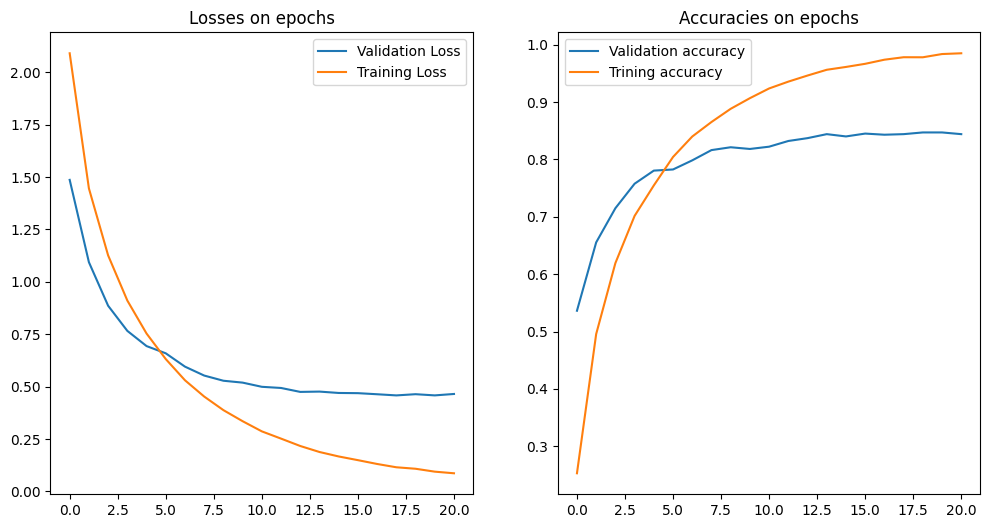

CPU times: user 1h 18min 35s, sys: 47.1 s, total: 1h 19min 22s
Wall time: 1h 19min 56s


In [ ]:
# Fitting the trainer
%%time
aug_model = MushroomResNet()
aug_trainer = pl.Trainer(max_epochs=30,
                     logger=logger,
                     callbacks=[early_stopping, MyPrintingCallback()])
aug_trainer.fit(aug_model, train_loader, valid_loader)

In [ ]:
# Saving checkpoint
torch.save(aug_model, "/content/drive/MyDrive/Colab Notebooks/know_your_mashroom/model_checkpoint.ckpt")

In [ ]:
# Testing on test set
aug_trainer.test(aug_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.836309552192688     │
│         test_loss         │     0.49165078997612      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.49165078997612, 'test_acc': 0.836309552192688}]

In [ ]:
# Getting predictions
preds = aug_trainer.predict(aug_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
# Classification report
y = []
for batch in test_loader:
    _, labels = batch
    y.append(labels.tolist())
y_true = np.array([item for sublist in y for item in sublist])

pred = [item.tolist() for item in preds]
y_hat = np.array([item for sublist in pred for item in sublist])
print(classification_report(y_true, y_hat, target_names=test_data.classes))

              precision    recall  f1-score   support

    Agaricus       0.82      0.70      0.76        53
     Amanita       0.86      0.85      0.85       113
     Boletus       0.94      0.93      0.93       161
 Cortinarius       0.83      0.82      0.82       126
    Entoloma       0.77      0.69      0.73        54
   Hygrocybe       0.90      0.94      0.92        47
   Lactarius       0.84      0.82      0.83       235
     Russula       0.77      0.87      0.82       173
     Suillus       0.74      0.74      0.74        46

    accuracy                           0.84      1008
   macro avg       0.83      0.82      0.82      1008
weighted avg       0.84      0.84      0.84      1008



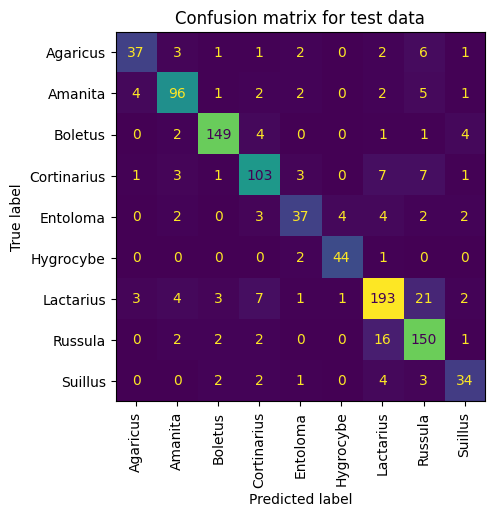

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_data.classes)
disp.plot(xticks_rotation=90, colorbar=False)
plt.title("Confusion matrix for test data");

# Conclusions
* Data augmentation and introducing dropout make the model more accurate
* The task is hard as the shape of mushrooms is similar
* Some not eadible mushrooms are recognized as eadible like Amanita mistakenly assigned to Agaricus or predicted species of other toxic mushrooms.
* The model has made the highiest number of mistakes on Rusulla and Lactarius which are visually similar. Both of them are toxic so they wouldn't cause poisoning.

# Improvements

* Using different method of loading and batching data as this would prevent unnecesary lines of code.
* Modeling on eadiable vs. uneadiable mushrooms and setting threshold to minimise poisoning - contacting mycologist.
* Checking different types of pretrained models from torchvision library.
* Checking results in tensorboard.
* Adding layers to the model.
